# US 2022 Stock Market Analysis

In this notebook, I will attempt to investigate how the various sectors of the US economy performed on the stock market in 2022 by creating a market cap-weighted index of each sector, and plotting its returns over the year.

The stocks are classified into these sectors according to the Global Industry Classification  Standard (GICS):
- Communication Services
- Consumer Discretionary
- Consumer Staples
- Energy
- Financials
- Healthcare
- Industrials 
- Information Technology
- Materials
- Real Estate
- Utilities


In [141]:
import yfinance as yf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [142]:
warnings.filterwarnings('ignore')

### Downloading stock data

I first had to get a table of all the stocks currently trading in the US. I downloaded the data below from the [NASDAQ Stock Screener](https://www.nasdaq.com/market-activity/stocks/screener).

In [2]:
# Data from NASDAQ stock screener
us_stocks = pd.read_csv('us_stocks.csv')

In [3]:
%%capture
us_stocks

In [4]:
us_stock_ticker_symbols = us_stocks['Symbol']

Next, I downloaded the 2022 price history of each stock, saving each in its own file in the folder `us_stocks`.
This price data is from [Yahoo Finance](https://finance.yahoo.com), accessed through the `yfinance` library.

In [5]:
%%capture
tickers_loaded = []
tickers_not_loaded = []
for i in us_stock_ticker_symbols:
    i = str(i) 
    ticker = i.replace('^', '-P')
    # Make sure there is no error associated with downloading the stock data
    try:
        data = yf.download(ticker, start='2022-01-01', end='2022-12-31')
    except:
        tickers_not_loaded += [ticker]
        continue
    # Make sure ticker was traded on all trading days in 2022
    # Also takes care of tickers that failed to download but did not raise an exception
    if len(data) != 251:
        tickers_not_loaded += [ticker]
        continue
    # / character is not allowed in file names
    file_name = ticker.replace('/','{slash}')
    data.to_csv(f'stock_data/{file_name}.csv')
    tickers_loaded += [ticker]

In [6]:
# Data of tickers that managed to load and tickers that did not. Needs to be changed to DataFrame to make using it easier
tickers_loaded = pd.DataFrame(tickers_loaded, columns=['Symbol'])
tickers_not_loaded = pd.DataFrame(tickers_not_loaded, columns=['Symbol'])

I need to replace '^' (found in NASDAQ stock tickers) with '-P' (found in Yahoo finance stock tickers). I also need to replace any '/' found in the ticker name with '{slash}' (as / is not allowed in file name)>

In [7]:
us_stocks['Symbol'] = us_stocks['Symbol'].replace({'\^': '-P'}, regex=True)
us_stocks['Symbol'] = us_stocks['Symbol'].replace({'/': '{slash}'}, regex=True)

### Cleaning up data (mostly renaming of Sectors

In this section, I clean up the data, making sure each stock has a Sector and Market Cap, and the Sector names are in line with the Global Industry Classification Standard (GICS).

In [8]:
# The breakdown of sectors according to NASDAQ
sectors = pd.DataFrame(us_stocks.groupby('Sector').count().index)

In [9]:
sectors

,Sector
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Healthcare
6,Industrials
7,Information Technology
8,Materials
9,Real Estate


In [10]:
us_stocks[us_stocks['Sector']=='Miscellaneous']

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [11]:
indexes_to_drop = list(us_stocks[us_stocks['Symbol'].isin(tickers_not_loaded['Symbol'])].index)

In [12]:
us_stocks.drop(indexes_to_drop, inplace=True)

In [13]:
# checking which tickers have a sector marked as Miscellaneous
us_stocks[us_stocks['Sector']=='Miscellaneous']

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [14]:
# checking which ickers have missing sectors
us_stocks[us_stocks['Sector'].isna()]

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [15]:
# Attempt to assign sector to tickers that have no sector
for i in range(len(us_stocks)):
    if pd.isnull(us_stocks.iloc[i]['Sector']):
        # check if it is a variant of an existing stock
        if ('-P' in us_stocks.iloc[i]['Symbol']) & (us_stocks.iloc[i]['Symbol'].split('-')[0] in us_stocks['Symbol'].values ):
            us_stocks.at[i,'Sector'] = str(us_stocks[us_stocks['Symbol']==us_stocks.iloc[i]['Symbol'].split('-')[0]]['Sector'].values[0])
            continue

        # get  sector classification from yahoo finance
        stock_yf_data = yf.Ticker(us_stocks.iloc[i]['Symbol']).info
        if 'sector' in stock_yf_data.keys():
            us_stocks.at[i,'Sector'] = stock_yf_data['sector']



In [16]:
# The stocks with sectors still missing
us_stocks[us_stocks['Sector'].isna() | us_stocks['Sector']=='Miscellaneous']

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [17]:
# Mannually replacing the remaining missing sectors
us_stocks.at[83,'Sector'] = 'Industrials'
us_stocks.at[102,'Sector'] = 'Utilities' # check if this is true
us_stocks.at[292,'Sector'] = 'Finance'
us_stocks.at[391,'Sector'] = 'Technology'
us_stocks.at[498,'Sector'] = 'Industrials'
us_stocks.at[639,'Sector'] = 'Consumer Discretionary'
us_stocks.at[931,'Sector'] = 'Industrials'
us_stocks.at[1120,'Sector'] = 'Consumer Discretionary'
us_stocks.at[1774,'Sector'] = 'Industrials'
us_stocks.at[1787,'Sector'] = 'Industrials'
us_stocks.at[1794,'Sector'] = 'Industrials'
us_stocks.at[1795,'Sector'] = 'Industrials'
us_stocks.at[2033,'Sector'] = 'Utilities'
us_stocks.at[2039,'Sector'] = 'Industrials'
us_stocks.at[2093,'Sector'] = 'Consumer Discretionary'
us_stocks.at[2094,'Sector'] = 'Consumer Discretionary'
us_stocks.at[2402,'Sector'] = 'Industrials'
us_stocks.at[2887,'Sector'] = 'Health Care'
us_stocks.at[2958,'Sector'] = 'Health Care'
us_stocks.at[3050,'Sector'] = 'Consumer Discretionary'
us_stocks.at[3058,'Sector'] = 'Health Care'
us_stocks.at[3571,'Sector'] = 'Technology'
us_stocks.at[3592,'Sector'] = 'Industrials'
us_stocks.at[3621,'Sector'] = 'Consumer Discretionary'
us_stocks.at[3692,'Sector'] = 'Utilities'
us_stocks.at[3721,'Sector'] = 'Industrials'
us_stocks.at[3758,'Sector'] = 'Industrials'
us_stocks.at[3968,'Sector'] = 'Technology'
us_stocks.at[3993,'Sector'] = 'Industrials'
us_stocks.at[4186,'Sector'] = 'Industrials'
us_stocks.at[4542,'Sector'] = 'Technology'
us_stocks.at[4612,'Sector'] = 'Consumer Discretionary'
us_stocks.at[4874,'Sector'] = 'Consumer Staples'
us_stocks.at[4986,'Sector'] = 'Technology'
us_stocks.at[5335,'Sector'] = 'Industrials'
us_stocks.at[5456,'Sector'] = 'Technology'
us_stocks.at[5625,'Sector'] = 'Consumer Discretionary'
us_stocks.at[5716,'Sector'] = 'Consumer Discretionary'
us_stocks.at[99,'Sector'] = 'Financials'
us_stocks.at[121,'Sector'] = 'Financials'
us_stocks.at[1286,'Sector'] = 'Energy'
us_stocks.at[1593,'Sector'] = 'Utilities'
us_stocks.at[2529,'Sector'] = 'Financials'
us_stocks.at[3163,'Sector'] = 'Utilities'
us_stocks.at[3296,'Sector'] = 'Financials'
us_stocks.at[3297,'Sector'] = 'Financials'
us_stocks.at[4018,'Sector'] = 'Utilities'
us_stocks.at[4021,'Sector'] = 'Utilities'
us_stocks.at[4022,'Sector'] = 'Financials'

In [18]:
us_stocks[us_stocks['Sector'].isna() | us_stocks['Sector']=='Miscellaneous']  # This confirms that no ticker has a missing sector

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector


In [19]:
sectors = pd.Series(us_stocks.groupby('Sector').count().index)
sectors

0     Communication Services
1     Consumer Discretionary
2           Consumer Staples
3                     Energy
4                    Finance
5                 Financials
6                Health Care
7                 Healthcare
8                Industrials
9     Information Technology
10                 Materials
11               Real Estate
12                Technology
13                 Utilities
Name: Sector, dtype: object

In [20]:
# Rename sectors to GICS sector names
us_stocks['Sector'].replace('Basic Materials','Materials', inplace=True)
us_stocks['Sector'].replace('Health Care','Healthcare', inplace=True)
us_stocks['Sector'].replace('Finance','Financials', inplace=True)
us_stocks['Sector'].replace('Technology','Information Technology', inplace=True)
us_stocks['Sector'].replace('Telecommunications','Communication Services', inplace=True)

In [21]:
sectors = pd.Series(us_stocks.groupby('Sector').count().index)
sectors 

0     Communication Services
1     Consumer Discretionary
2           Consumer Staples
3                     Energy
4                 Financials
5                 Healthcare
6                Industrials
7     Information Technology
8                  Materials
9                Real Estate
10                 Utilities
Name: Sector, dtype: object

In [22]:
# Rename sectors to their GICS names
us_stocks['Sector'].replace('Consumer Cyclical','Consumer Discretionary', inplace=True)
us_stocks['Sector'].replace('Consumer Defensive','Consumer Staples', inplace=True)
us_stocks['Sector'].replace('Financial Services','Financials', inplace=True)
us_stocks['Sector'].replace('Technology','Information Technology', inplace=True)
us_stocks['Sector'].replace('Basic Materials','Materials', inplace=True)

In [23]:
# Now to clean up the market capitalisation data
us_stocks[us_stocks['Market Cap'].isna()]

,Unnamed: 0.1,level_0,Unnamed: 0,index,Symbol,Name,Market Cap,Sector
1774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
1787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
1794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
1795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Utilities
2039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
2093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary
2094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consumer Discretionary
2402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Industrials
2887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Healthcare


In [37]:
us_stocks.dropna(subset=['Symbol'], inplace=True)

In [38]:
# To make things easier we're going to use the Market Cap of the stock today (instead of in 2022). This means the indexes won;t be entirely accurate, but they should be close enough
# For the stocks with NaN Market Caps, we will try download market cap data from Yahoo Finance
for i in range(len(us_stocks)):
    if pd.isnull(us_stocks.iloc[i]['Market Cap']):

        # get market cap from yahoo finance (if data exists)
        stock_yf_data = yf.Ticker(str(us_stocks.iloc[i]['Symbol'])).info
        if 'marketCap' in stock_yf_data.keys():
            us_stocks.at[i,'Market Cap'] = stock_yf_data['marketCap']
            continue

        #if there's no data on yahoo finance, get average market cap of the sector
        stock_sector = us_stocks.iloc[i]['Sector']
        us_stocks.at[i,'Market Cap'] = us_stocks[us_stocks['Sector']==stock_sector]['Market Cap'].mean()

For testing purposes, `us_stocks`, I calculate the mean Market Cap:

In [39]:
us_stocks[(us_stocks['Sector']=='Financials') & (~us_stocks['Market Cap'].isna())]['Market Cap'].mean() #the mean market capitalisation

9695819081.708857

In [40]:
us_stocks.drop(['level_0','Unnamed: 0','index'],axis=1, inplace=True)

Any rows with missing items are dropped at this point - I haven't been able to find the data.

In [41]:
us_stocks.dropna(inplace=True)

### Starting off - building an S&P 500 Equal Weight Index, and S&P500 normal index

I start off with building an S&P500 Equal Weight Index (for simplicity). This is the S&P 500 index, but with each stock having an equal weighting in the index.

In [144]:
# Add a percentage change column to all stock csvs in stock_data, and drop unnecessary columns
successful = []
for i in us_stocks['Symbol']:
    stock_data = pd.read_csv(f'stock_data/{i}.csv')
    #stock_data.drop(['Open','High','Low','Close','Volume'], axis=1, inplace=True)
    stock_data['% change'] = stock_data['Adj Close'].pct_change()
    stock_data.at[0,'% change'] = 0
    stock_data.to_csv(f'stock_data/{i}.csv')
    successful += [i]

<Axes: >

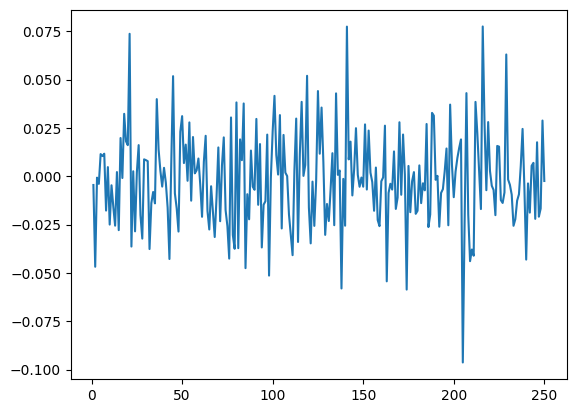

In [145]:
pd.read_csv('stock_data/GOOG.csv').drop(['Open','High','Low','Close','Volume'], axis=1)['Adj Close'].pct_change().plot()

For testing purposes, I plot the daily percentage change in Google's GOOG stock, for 2022:

A dataframe of S&P 500 tickers is scraped from a wikipedia article:

In [146]:
# Get dataframe of tickers in the S&P500 index
snp_ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0][['Symbol']]

In [147]:
snp_ticker_list['Symbol']

0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object

Then I isolate the S&P 500 tickers I managed to download (and managed to fill in missing data):

In [148]:
%%capture
exists = []
for i in snp_ticker_list['Symbol']:
    print(i)
    if os.path.exists(f'stock_data/{i}.csv') and '% change' in pd.read_csv(f'stock_data/{i}.csv'):
        exists += [i]

In [149]:
# These are the tickers that are in the S&P500, but for some reason, had to be dropped. We will disregard these to make the project easier
snp_ticker_list[~snp_ticker_list['Symbol'].isin(exists)]


,Symbol
0,MMM
4,ACN
19,LNT
21,GOOGL
22,GOOG
...,...
450,TT
468,VLTO
475,VICI
493,WTW


`snp_weights` is a list of the tickers' relative weights. As this is an Equal Weight Index, each stock has an equal weighting:

In [150]:
snp_weights = np.repeat(1/len(exists),len(exists)) # creating a list of weights, with each stock having equal weighting in this case

`snp_index` contains the daily returns of each stock in the index, on each trading day in 2022:

In [151]:
%%capture
snp_index = pd.DataFrame()
for i in exists:
    snp_index[i] = pd.read_csv(f'stock_data/{i}.csv')['% change']
    


The `index_returns` variable is added to `snp_index`, and this is the calculation of the index's returns on each trading day in 2022:

In [152]:
snp_index['index_returns'] = snp_index.mul(snp_weights,axis=1).sum(axis=1)
snp_index

,AOS,ABT,ABBV,ADM,ADBE,ADP,AES,AFL,A,ABNB,...,WMB,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS,index_returns
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.016633,-0.023518,-0.001920,0.018559,-0.018374,0.004672,0.002871,0.032779,-0.033806,-0.010887,...,0.009057,-0.003190,0.006329,0.010608,0.005347,0.006337,0.010145,0.028487,-0.038072,0.007829
2,-0.016714,-0.004493,0.005253,-0.007809,-0.071426,-0.008525,-0.045808,-0.001662,-0.017131,-0.050059,...,0.002244,-0.037033,0.009800,-0.013629,-0.012677,-0.050068,-0.003297,0.002270,-0.038024,-0.016183
3,0.006703,-0.000148,-0.004710,0.008891,-0.000603,-0.006871,-0.003858,0.018475,0.003499,-0.015408,...,0.023880,0.004629,-0.007822,-0.001373,0.010330,-0.005410,-0.008307,0.041075,0.003971,0.002374
4,-0.011296,0.003108,-0.002588,0.008523,-0.006652,-0.010564,-0.006024,0.015852,-0.026623,0.039437,...,0.020773,-0.001063,0.008759,-0.007992,-0.011467,-0.043771,-0.006050,0.016681,-0.029114,-0.002889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,0.011915,0.001388,-0.001041,0.012087,0.005735,0.007443,0.013070,0.011846,0.001476,0.004477,...,0.023027,-0.006401,0.012852,-0.000729,0.000621,0.002869,0.001106,0.003521,0.005033,0.006626
247,0.013532,0.003605,-0.000674,0.013634,-0.009928,0.000374,0.004881,0.006829,0.002144,-0.020645,...,0.002701,0.044723,0.009023,0.009022,0.007758,0.011200,0.004657,0.008050,-0.003156,0.000643
248,-0.015606,-0.006816,-0.004663,-0.023877,-0.020174,-0.013193,-0.017349,-0.010659,-0.009763,-0.011977,...,-0.020652,-0.050279,-0.007203,-0.016077,-0.004542,-0.016574,-0.010135,-0.017813,-0.010117,-0.013343
249,0.015677,0.022999,0.002034,-0.005341,0.028173,0.011646,0.017302,0.008535,0.020258,0.033216,...,0.007641,0.014609,0.007085,0.024784,0.005259,0.043307,0.014604,0.023140,0.030035,0.017818


The index returns are converted to cumulative returns to give the total returns through time

In [153]:
snp_index['cumulative returns'] = ((1+snp_index['index_returns']).cumprod()-1)

And the result is plotted. The resulting plot is very similar to the actual S&P 500 EWI graph, indicating that the tickers that had to be excluded did not have a major effect on the final result.

<Axes: >

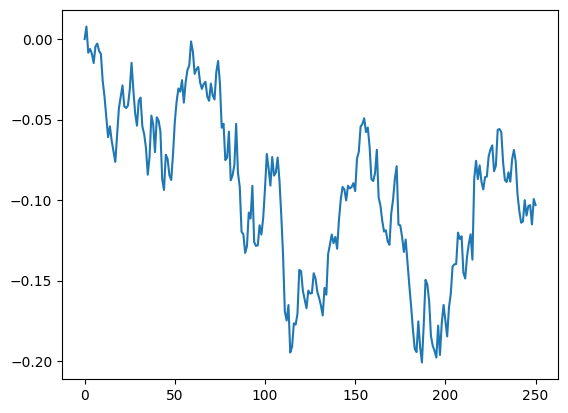

In [154]:
snp_index['cumulative returns'].plot()
# Quite close to actual graph but not perfect - year change is about 1 percentage point from the actual value

I then follow the same steps to create the actual S&P 500 (weighted) index:

<Axes: >

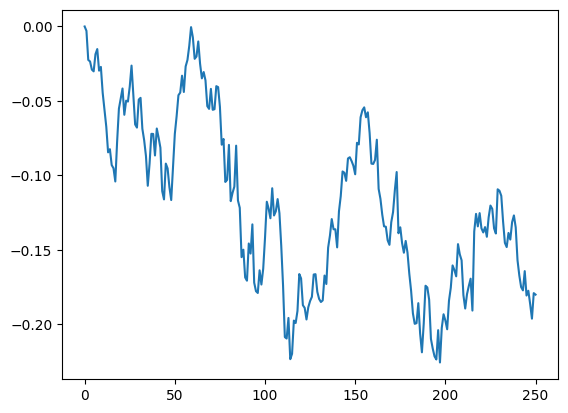

In [155]:
# To create a market cap weighted index
snp_weights = []
for i in snp_index:
    try:
        mktcap = float(us_stocks[us_stocks['Symbol']==i]['Market Cap'].iloc[0])
    except:
        mktcap = 0
    snp_weights += [mktcap/us_stocks[us_stocks['Symbol'].isin(exists)]['Market Cap'].sum()]
#snp_index.drop(['index_returns','cumulative returns'], axis=1, inplace=True)
snp_index['index_returns'] = snp_index.mul(snp_weights,axis=1).sum(axis=1)
snp_index['cumulative returns'] = ((1+snp_index['index_returns']).cumprod()-1)
snp_index['cumulative returns'].plot()

In [156]:
len(snp_weights)

267

In [157]:
snp_index['cumulative returns'].iloc[250] # actual return is -0.1944, so this one is about 2 percentage points from the actual

-0.17998758588466335

### Next Step: making an index of each industries in the US

In [158]:
sectors

0     Communication Services
1     Consumer Discretionary
2           Consumer Staples
3                     Energy
4                 Financials
5                 Healthcare
6                Industrials
7     Information Technology
8                  Materials
9                Real Estate
10                 Utilities
Name: Sector, dtype: object

In [159]:
# compute the different weights of each industry based on market capitalisation
industry_weights = {}
for i in sectors:
    weights = []
    industry_tickers = list(us_stocks[us_stocks['Sector'] == i]['Symbol'])

    for j in industry_tickers:
        market_cap = float(us_stocks[us_stocks['Symbol']==j]['Market Cap'])
        weights += [market_cap/us_stocks[us_stocks['Symbol'].isin(industry_tickers)]['Market Cap'].sum()]
    industry_weights[i] = weights

In [160]:
# Compute the cumulative returns of all sectors
industry_return_data = pd.DataFrame()
for i in sectors:
    return_data = pd.DataFrame()
    industry_tickers = list(us_stocks[us_stocks['Sector'] == i]['Symbol'])
    for j in industry_tickers:
        return_data[j] = pd.read_csv(f'stock_data/{j}.csv')['% change']
    return_data['index_returns'] = return_data.mul(industry_weights[i],axis=1).sum(axis=1)
    return_data['cumulative returns'] = ((1+return_data['index_returns']).cumprod()-1)
    industry_return_data[i] = return_data['cumulative returns'] # this is all we need. We can throw out the rest

The result is a plot of the performance of each of the sectors on the stock market:

<Axes: >

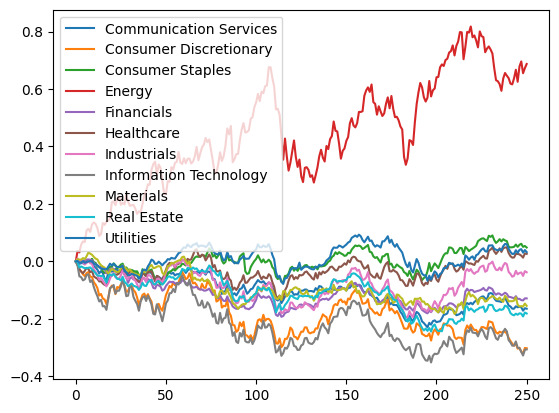

In [161]:
industry_return_data.plot()

The **Energy** sector gained a whooping 60%! This was largely the result of the war in Ukraine pushing up oil prices to record highs. The **Information Technology** sector, on the other hand, declined about 30%. Analysts attribute this to high interest rates, high inflation, and a generally uncertain business environment.